In [1]:
# Function to decode operation

In [5]:
%pylab inline 

import mne
from mne.datasets import spm_face
from mne.decoding import GeneralizationAcrossTime
import sys
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from scipy import stats
#Add personal functions to python path
#sys.path.append('/Users/pinheirochagas/Pedro/NeuroSpin/Experiments/Calc_MEG/scripts/decoding/')
sys.path.append('/Volumes/NeuroSpin2T/Calculation_Pedro_2014/scripts/decoding/')
from fldtrp2mne import fldtrp2mne
from sklearn import svm
from sklearn.cross_validation import cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


In [6]:
#Directories
#data_path = '/Users/pinheirochagas/Pedro/NeuroSpin/Experiments/Calc_MEG/data/mat/'
#result_path = '/Users/pinheirochagas/Pedro/NeuroSpin/Experiments/Calc_MEG/data/decoding/'
data_path = '/Volumes/NeuroSpin2T/Calculation_Pedro_2014/data/mat/'
result_path = '/Volumes/NeuroSpin2T/Calculation_Pedro_2014/data/decoding/'

#Subjects
subjects = 's04'

#General parameters
baseline = (-0.5, -0.05)
downsampling = 4

#Decoding
trainset = 'all'
testset = 'all'
decCond = ['addition', 'subtraction']

params = {'baseline': baseline, 'downsampling': downsampling, 
'Classification': decCond, 'trainset': trainset, 'testset': testset}

#Results initialization
all_scores = []
all_diagonals = []


In [11]:
#Load filtered MEG data from fieldtrip
print('Loading data for subject: ' + subjects)
    
fname = op.join(data_path, subjects + '_calc.mat') 
epoch = fldtrp2mne(fname, 'data')

matfile = sio.loadmat(fname)

trialinfo = matfile['data']['trialinfo']

operator = trialinfo[0][0][0][0][2].T
operand1 = trialinfo[0][0][0][0][1].T


Loading data for subject: s04


In [12]:
info = pd.DataFrame(data = np.concatenate((operator, operand1), axis = 1), 
                        columns = ['operation', 'operand1'])

In [13]:
addition = info['operation'] == 1
subtraction = info['operation'] == -1

add_sub = info['operation'] != 0

condA = addition
condB = subtraction

In [14]:
evoked_condA = epoch[condA].average() #seen
evoked_condB = epoch[condB].average() #unseen


/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


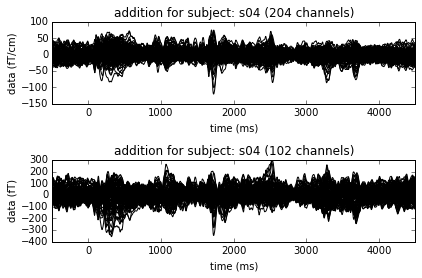

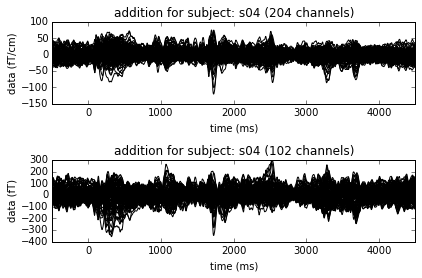

In [15]:
evoked_condB.plot(titles = decCond[0] + ' for subject: ' + subjects, show = False)

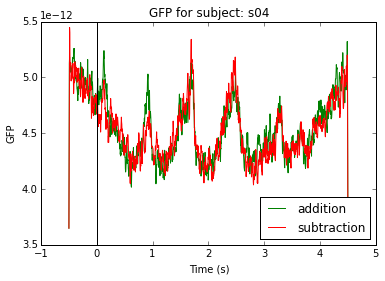

In [16]:
gfp_condA = np.median(np.std(epoch[condA]._data, axis = 1), axis = 0) #do I need to make sure that the number of trials is similar in the two conditions?
gfp_condB = np.median(np.std(epoch[condB]._data, axis = 1), axis = 0)
    
plt.plot(epoch.times, gfp_condA, color = 'g', label = decCond[0])
plt.plot(epoch.times, gfp_condB, color = 'r', label = decCond[1])
plt.axvline(0, color = 'k') #mark stimulus onset
plt.legend(loc = 'lower right')
plt.xlabel('Time (s)')
plt.ylabel('GFP')
plt.title('GFP for subject: ' + subjects)
plt.show()

In [17]:
# Decoding
epochs = epoch[add_sub] #select only target-present trials
info = info[add_sub]
y = np.array(info['operation']) #select labels for seen vs. unseen


In [18]:
epochs.decimate(4)

/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/mne/epochs.py:394: UserWarning: The measurement information indicates a low-pass frequency of 125 Hz. The decim=4 parameter will result in a sampling frequency of 62.5 Hz, which can cause aliasing artifacts.
  % (lowpass, decim, new_sfreq))  # > 50% nyquist limit


<EpochsArray  |  n_events : 314 (all good), tmin : -0.5 (s), tmax : 4.492 (s), baseline : None>

In [19]:
type(y[0])

y = y.astype(numpy.float64)

In [20]:
score = []
scaler = StandardScaler();
model = svm.SVC(C = 1, kernel = 'linear', class_weight = 'balanced')
clf = make_pipeline(scaler, model)
cv = StratifiedKFold(y, 5)


In [21]:
gat = GeneralizationAcrossTime(clf=clf, cv=cv, n_jobs=-1)


In [22]:
epochs

<EpochsArray  |  n_events : 314 (all good), tmin : -0.5 (s), tmax : 4.492 (s), baseline : None>

In [23]:
gat.fit(epochs, y=y)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  2.0min finished
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class

<GAT | fitted, start : -0.500 (s), stop : 4.492 (s), no prediction, no score>

/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic i

/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/Users/pinheirochagas/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic i

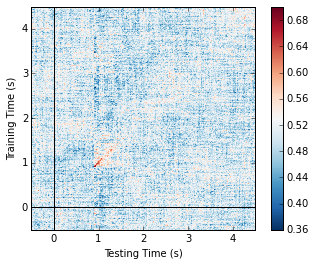

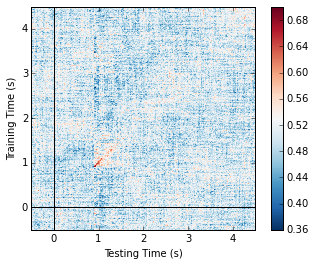

In [24]:
gat.score(epochs, y=y)
gat.plot()

In [26]:
gat.score

<bound method GeneralizationAcrossTime.score of <GAT | fitted, start : -0.500 (s), stop : 4.492 (s), predicted 314 epochs,
 scored (accuracy_score)>>

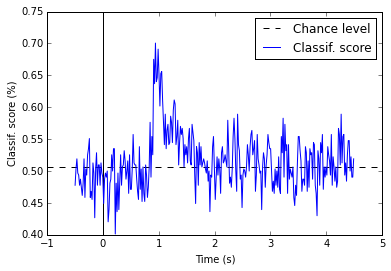

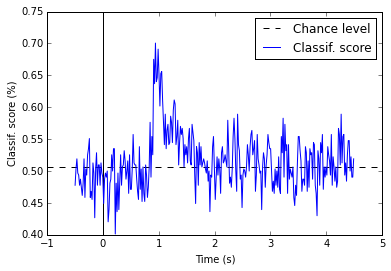

In [27]:
gat.plot_diagonal()  # plot decoding across time (correspond to GAT diagonal)
